# Workshop on RGB-D semantic segmentation

Course: NICF- Spatial Reasoning from Sensor Data (SF), https://www.iss.nus.edu.sg/executive-education/course/detail/spatial-reasoning-from-sensor-data/artificial-intelligence

Contact: Tian Jing

Email: tianjing@nus.edu.sg

## Objective

Visualize the RGB-D data
Perform RGB-D semantic segmentation using the FCN approach

## Installation guideline

- Open `Anaconda Prompt`

- Append the channel `conda-forge` into your conda configuration.

`conda config --append channels conda-forge`

- Create a new virtual environment `srsdv` or install additional packages in your own environment

`conda create -n srsdv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow=1.10.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras=2.2.4 notebook=5.7.4`

- Activate the environment `srsdv`

`conda activate srsdv`

- Browse to the folder that contains the workshop files, then run Jupyter Notebook

`jupyter notebook`

## Reference

- Original dataset: **NYU Depth Dataset V2** dataset, https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html The original files is in .mat format (2.8 GB), http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat

- Train RGB images (795 files): http://www.doc.ic.ac.uk/~ahanda/nyu_train_rgb.tgz
- Test RGB images (654 files): http://www.doc.ic.ac.uk/~ahanda/nyu_test_rgb.tgz
- Depth images (1449 files): https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html
- Train/Test split: https://github.com/ankurhanda/nyuv2-meta-data
- 13 categories labels: https://github.com/ankurhanda/nyuv2-meta-data

## Submission guideline
Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.


In [1]:
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import np_utils
from keras.models import Model
from keras.layers import *
from keras.layers.convolutional import Conv2D, MaxPooling2D, Deconv2D, Conv2DTranspose
import keras
from keras import backend as K
from PIL import Image
import scipy.io as scio
import time
from keras.models import model_from_json


Using TensorFlow backend.


In [15]:
import keras.backend as K

#K.set_floatx("float32")
#K.set_epsilon(1e-7)

In [2]:

def display_labels_truth(image):
# Input image must be gray label image
    class_num = 14
    color = [0] * class_num

    color[0] = [0,0,0]
    color[1] = [128,0,0]
    color[2] = [192,192,128]
    color[3] = [255,69,0]
    color[4] = [128,64,128]
    color[5] = [60,40,222]
    color[6] = [128,128,0]
    color[7] = [192,128,128]
    color[8] = [64,64,128]
    color[9] = [64,0,128]
    color[10] = [64,64,0]
    color[11] = [0,128,192]
    color[12] = [128,128,128]
    color[13] = [0, 0, 128]

    height, width = image.shape
    outarray = np.zeros((height, width, 3), np.uint8)

    for h in range(height):
        for w in range(width):
            outarray[h, w, :] = color[image[h,w]]

    return outarray

def display_labels_one_hot(onehotarray):

    class_num = 14
    color = [0] * class_num

    color[0] = [0,0,0]
    color[1] = [128,0,0]
    color[2] = [192,192,128]
    color[3] = [255,69,0]
    color[4] = [128,64,128]
    color[5] = [60,40,222]
    color[6] = [128,128,0]
    color[7] = [192,128,128]
    color[8] = [64,64,128]
    color[9] = [64,0,128]
    color[10] = [64,64,0]
    color[11] = [0,128,192]
    color[12] = [128,128,128]
    color[13] = [0, 0, 128]

    height, width = onehotarray.shape[:2]
    outarray = np.zeros((height, width, 3), np.uint8)

    for h in range(height):
        for w in range(width):
            vec = onehotarray[h, w, :]
            idx = np.argmax(vec)
            outarray[h, w, :] = color[idx]

    return outarray

## Exercise 1: Visualize the RGB-D images and their ground truth label

data/train/nyu_images/nyu_rgb_0012.png
data/train/nyu_depths/nyu_depth_0012.png
data/train/nyu_labels/new_nyu_class13_0012.png


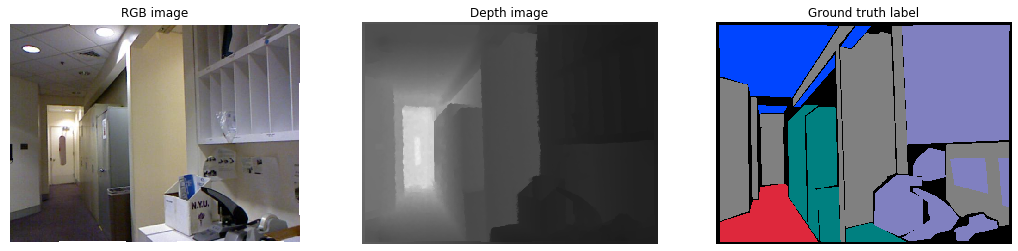

In [3]:
idx = 12
image_color_file = ("data/train/nyu_images/nyu_rgb_" + str(idx).zfill(4) + ".png")
image_depth_file = ("data/train/nyu_depths/nyu_depth_" + str(idx).zfill(4) + ".png")
image_label_file = ("data/train/nyu_labels/new_nyu_class13_" + str(idx).zfill(4) + ".png")
print(image_color_file)
print(image_depth_file)
print(image_label_file)


image_color = cv2.imread(image_color_file)
image_depth = cv2.imread(image_depth_file)
image_label = cv2.imread(image_label_file, 0)
image_label = display_labels_truth(image_label)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB) / 255)
plt.title("RGB image")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(image_depth, cv2.COLOR_BGR2RGB) / 255)
plt.title("Depth image")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(image_label, cv2.COLOR_BGR2RGB) / 255)
plt.title("Ground truth label")
plt.axis("off")

plt.show()

In [4]:
class ImageDataGenerator_new(object):
    def __init__(self):
        self.__bit8 = 255

        self.dirname = None
        self.reset()

        self.out_height = 480
        self.out_width = 640


    def reset(self):
        self.images = []
        self.labels = []

    def flow_from_directory(self, dirname, height=480, width=640, list_limit=1000):

        self.dirname = dirname
        self.out_height = height
        self.out_width = width

        out_list = []
        for state in ['train', 'test']:
            image_names = os.listdir(
                os.path.join(self.dirname, state, 'nyu_images')
                )

            num_samples = len(image_names)
            print("Process ", state, "folder")

            # make [[color_name, depth_name], label_name] list
            data_path_list = []
            for image_name in image_names:
                depth_file_name = image_name.replace("rgb", "depth")
                label_file_name = image_name.replace("nyu_rgb", "new_nyu_class13")

                color_path = os.path.join(self.dirname, state, 'nyu_images', image_name)
                depth_path = os.path.join(self.dirname, state, 'nyu_depths', depth_file_name)

                label_path = os.path.join(self.dirname, state, 'nyu_labels', label_file_name)

                data_path_list.append(
                    ([color_path, depth_path], label_path))


            # random shuffle
            if list_limit>len(data_path_list):
                data_path_list = np.random.permutation(data_path_list)
            else:
                data_path_list = data_path_list[0:list_limit]

            x_list = []
            y_list = []

            for (imagedepth_path, label_path) in data_path_list:
                image_path = imagedepth_path[0]
                depth_path = imagedepth_path[1]

                image = self.__load_image(image_path)
                depth = self.__load_depth(depth_path)
                label = self.__load_label(label_path)

                # make 4ch array (B, G, R, D)
                x = np.dstack((image, depth))
                x_list.append(x)
                y_list.append(label)

            out_list.append((np.array(x_list), np.array(y_list)))

        return out_list

    def __load_depth(self, filename):
        image_depth = cv2.imread(filename, 0)
        if image_depth is None:
            print('Load Error: {}'.format(filename))
            sys.exit()

        depth = np.float32(image_depth) / 127.5-1
        depth = cv2.resize(depth, (self.out_width, self.out_height))
        #print(depth.shape)
        return depth

    def __load_image(self, filename, image_max=1.0):

        image_color = cv2.imread(filename, 1)
        if image_color is None:
            print('Load Error: {}'.format(filename))
            sys.exit()

        image = np.float32(image_color) / 127.5-1
        image = cv2.resize(image, (self.out_width, self.out_height))

        return image

    def __load_label(self, filename):
        label = cv2.imread(filename, 0)

        if label is None:
            print('Load Error: {}'.format(filename))
            sys.exit()

        label = cv2.resize(label, (self.out_width, self.out_height))
        label = label[:, :, None] # 2ch to 3ch

        label_onehot = np_utils.to_categorical(label, 14)
        return np.float32(label_onehot)


In [5]:
# Define FCN8 model model
# Reference: Fully Convolutional Networks (FCN) for 2D segmentation, http://deeplearning.net/tutorial/fcn_2D_segm.html
        
def FCN_VGG16_8s_full(input_shape, class_num):

    # input
    input = Input(shape=input_shape) # (h, w, c)
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)## (None, 7, 7, 512)
  
    o = ( Conv2D(4096 , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6"))(pool5)
    conv7 = ( Conv2D( 4096, ( 1 , 1 ) , activation='relu' , padding='same', name="conv7"))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( class_num , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False)(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( class_num , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11"))(pool4)
    pool411_2 = (Conv2DTranspose( class_num , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False))(pool411)
    
    pool311 = ( Conv2D( class_num , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11"))(pool3)
        
    print(pool411_2.shape, pool311.shape, conv7_4.shape)
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( class_num , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(input, o)

    return model


In [6]:
print(FCN_VGG16_8s_full)

# Note: It taks around 2 hour to train the model in 200 epoches.
# #  Prepare dataset
height = 480
width = 640
ch = 4
class_num = 14

start_time = time.time()
loader = ImageDataGenerator_new()
(x_train, y_train), (x_test, y_test) = loader.flow_from_directory('data', height=height, width=width, list_limit=200)
print("Prepare dataset: %s seconds " % (time.time() - start_time))
print(x_train.shape)
print(x_test.shape)

# Define model

input_shape = (height, width, ch)
model = FCN_VGG16_8s_full(input_shape, class_num)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(),metrics=['accuracy'])
model.summary()
batch_num = 4
model.fit(x_train, y_train, batch_size=batch_num, verbose=1, epochs=100, validation_data=(x_test, y_test))

# Save trained models into harddisk
#model_json = model.to_json()
#with open("nyu_rgbd_200_v0805.json", "w") as json_file:
#    json_file.write(model_json)
# # serialize weights to HDF5
#model.save_weights("nyu_rgbd_200_v0805.h5")
# print("Saved model to disk")
#np.savez_compressed('nyu_rgbd_200', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)


<function FCN_VGG16_8s_full at 0x000001BDD4348620>
Process  train folder
Process  test folder
Prepare dataset: 12.322078466415405 seconds 
(200, 480, 640, 4)
(200, 480, 640, 4)
Instructions for updating:
Colocations handled automatically by placer.
(?, ?, ?, 14) (?, 60, 80, 14) (?, ?, ?, 14)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 4)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 640, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 640, 64) 36928       block1_conv1[0][0]               
______________

200/200 [==============================] - 43s 215ms/step - loss: 2.0305 - acc: 0.2551 - val_loss: 2.2027 - val_acc: 0.2867
Epoch 8/100
200/200 [==============================] - 43s 215ms/step - loss: 1.9986 - acc: 0.2906 - val_loss: 2.1046 - val_acc: 0.3202
Epoch 9/100
200/200 [==============================] - 43s 215ms/step - loss: 1.9000 - acc: 0.3262 - val_loss: 1.9747 - val_acc: 0.3415
Epoch 10/100
200/200 [==============================] - 43s 215ms/step - loss: 1.8311 - acc: 0.3532 - val_loss: 1.9414 - val_acc: 0.3621
Epoch 11/100
200/200 [==============================] - 43s 215ms/step - loss: 1.8026 - acc: 0.3556 - val_loss: 1.9023 - val_acc: 0.3666
Epoch 12/100
200/200 [==============================] - 43s 215ms/step - loss: 1.7465 - acc: 0.3847 - val_loss: 1.8629 - val_acc: 0.3612
Epoch 13/100
200/200 [==============================] - 43s 215ms/step - loss: 1.7437 - acc: 0.3825 - val_loss: 1.8809 - val_acc: 0.3513
Epoch 14/100
200/200 [==============================] - 

Epoch 67/100
200/200 [==============================] - 43s 215ms/step - loss: 0.2023 - acc: 0.9240 - val_loss: 3.2628 - val_acc: 0.4399
Epoch 68/100
200/200 [==============================] - 43s 215ms/step - loss: 0.1947 - acc: 0.9269 - val_loss: 3.3742 - val_acc: 0.4423
Epoch 69/100
200/200 [==============================] - 43s 215ms/step - loss: 0.1846 - acc: 0.9306 - val_loss: 3.4071 - val_acc: 0.4406
Epoch 70/100
200/200 [==============================] - 43s 215ms/step - loss: 0.1754 - acc: 0.9339 - val_loss: 3.5429 - val_acc: 0.4392
Epoch 71/100
200/200 [==============================] - 43s 215ms/step - loss: 0.1688 - acc: 0.9363 - val_loss: 3.5805 - val_acc: 0.4362
Epoch 72/100
200/200 [==============================] - 43s 215ms/step - loss: 0.1647 - acc: 0.9379 - val_loss: 3.7171 - val_acc: 0.4380
Epoch 73/100
200/200 [==============================] - 43s 215ms/step - loss: 0.1626 - acc: 0.9387 - val_loss: 3.6046 - val_acc: 0.4337
Epoch 74/100
200/200 [===================

## Exercise 2: Perform RGB-D semantic segmentation using pre-trained model

- Load train and test data from `nyu_rgbd_200.npz`

- Load model structure from `nyu_rgbd_200_v0805.json`

- Load model weights from `nyu_rgbd_200_v0805.h5`

In [7]:
start_time = time.time()

data_file = np.load('data\\nyu_rgbd_200.npz')
x_train = data_file["x_train"]
y_train = data_file["y_train"]
x_test = data_file["x_train"]
y_test = data_file["y_test"]

print(x_train.shape)
print(x_test.shape)
print("Load dataset: %.4s seconds " % (time.time() - start_time))



(200, 480, 640, 4)
(200, 480, 640, 4)
Load dataset: 15.0 seconds 


In [9]:
# load json and create model

loaded_model = model

start_time = time.time()

#json_file = open('data\\nyu_rgbd_200_v0805.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("data\\nyu_rgbd_200_v0805.h5")

loaded_model.summary()

#print("Load model: %.4f seconds " % (time.time() - start_time))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 4)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 640, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 640, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 320, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

(480, 640, 14)
(480, 640, 3)


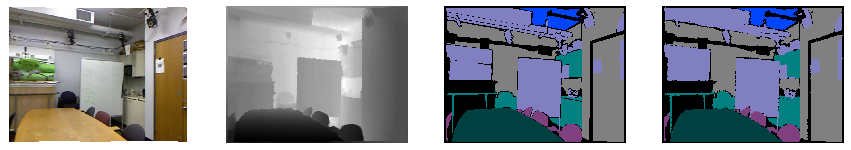

In [10]:
idx = 2

sample_test = x_train[idx]
sample_rgb = sample_test[:,:,0:3]
sample_rgb = (sample_rgb+1)*127.5/255.0
sample_depth = sample_test[:,:,3]
sample_test = sample_test[None, :, :, :]
sample_truth = y_train[idx]

sample_pred = loaded_model.predict(sample_test)[0, ...]
print(sample_pred.shape)
result = display_labels_one_hot(sample_pred)
print(result.shape)

plt.figure(figsize=(15,6))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(sample_rgb, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1,4,2)
plt.imshow(sample_depth, cmap='gray')
plt.axis("off")
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(display_labels_one_hot(sample_truth), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

$\color{red}{\text{Q1. Complete the following code to implement the Dice loss function}}$

Tasks
- Implement the Dice loss function
- Select one test rgb-d image
- Perform semantic segmentation
- Compare the segmentation result and the ground truth using your Dice loss function


In [10]:
# Provide your solution to Q1 here
#
#
#
#


**Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.**

Have a nice day!